# VASP TiO2 benchmark performance

This notebook compares the performance of the TiO2 benchmark across different HPC facilities.

We compute the mean time per SCF cycle from all cycles in the output file apart from the fastest and slowest cycle times. Performance is plotted as SCF cycles per second.

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')

In [3]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

../../../python-modules/utilities/sysinfo.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  systems = yaml.load(input)


## Process data

In [5]:
results = ['ARCHER','ARCHER2','ARCHER2-MKL193']
systems = {'ARCHER': 'ARCHER', 'ARCHER2': 'ARCHER2', 'ARCHER2-MKL193': 'ARCHER2'}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../TiO2/results/' + res
    filelist = filemanip.get_filelist(wdir, 'TiO2MCC_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode']))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER
                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
2     48        1       4    1     0.001440  0.001440  0.001440  0.001440   
                        8    1     0.001389  0.001389  0.001389  0.001389   
4     96        1       4    1     0.002790  0.002790  0.002790  0.002790   
                        8    1     0.002805  0.002805  0.002805  0.002805   
8     192       1       4    1     0.005267  0.005267  0.005267  0.005267   
16    384       1       4    1     0.009385  0.009385  0.009385  0.009385   
32    768       1       4    1     0.020009  0.020009  0.020009  0.020009   

                                          SCF                          \
                                          min      median         max   
Nodes Processes Threads NPAR KPAR                                       
2 

                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
1     128       1       4    1     0.002926  0.002926  0.002926  0.002926   
2     256       1       2    1     0.007152  0.007152  0.007152  0.007152   
4     512       1       4    1     0.013682  0.013682  0.013682  0.013682   
                        128  1     0.009714  0.009714  0.009714  0.009714   
8     1024      1       8    1     0.024259  0.024259  0.024259  0.024259   
                        128  1     0.019502  0.019502  0.019502  0.019502   
16    2048      1       16   1     0.041755  0.041755  0.041755  0.041755   
                        128  1     0.032878  0.032878  0.032878  0.032878   
32    4096      1       64   1     0.056970  0.056970  0.056970  0.056970   

                                          SCF                          \
  

## Performance Comparison

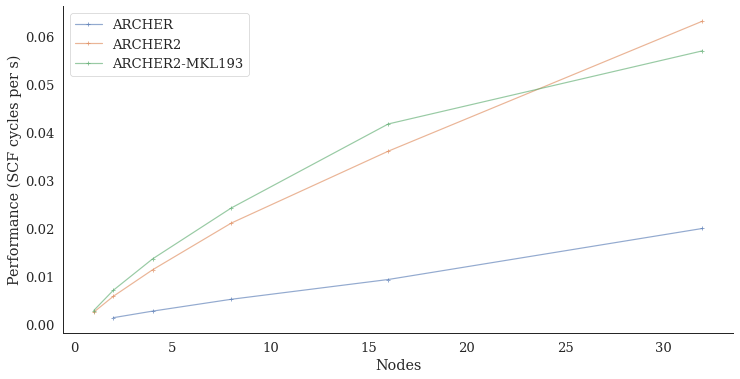

In [6]:
for res in results:
    plt.plot(nodes[res], perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

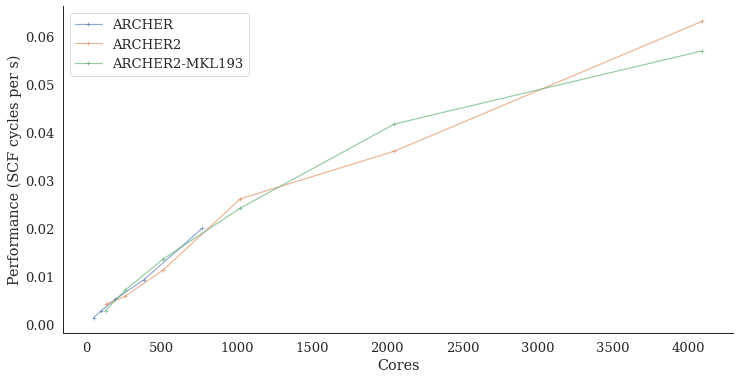

In [7]:
for res in results:
    plt.plot(cores[res], perf_cores[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

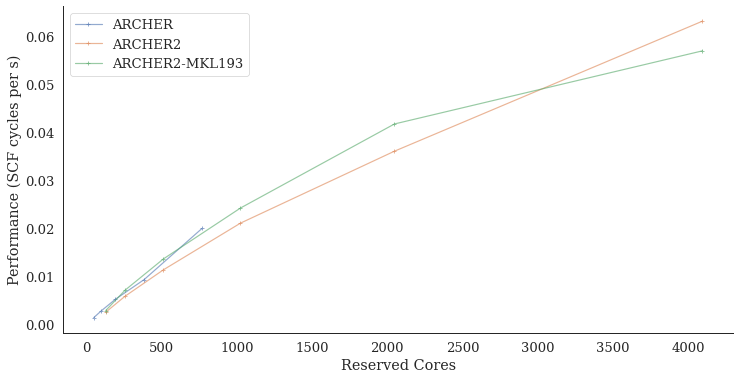

In [8]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

## ARCHER2 Cray LibSci vs. MKL performance

A comparison of the performance of the same version of VASP using different numerical libraries

In [9]:
print(f"{'Nodes':>5s} {'LibSci':>10s} {'MKL':>10s} {'Ratio':>10s}")
for i in range(min(len(nodes['ARCHER2']),len(nodes['ARCHER2-MKL193']))):
    n = nodes['ARCHER2'][i]
    perfLS = perf_nodes['ARCHER2'][i]
    perfMKL = perf_nodes['ARCHER2-MKL193'][i]
    ratio = perfLS/perfMKL
    print(f"{n:>5d} {perfLS:>10.5f} {perfMKL:>10.5f} {ratio:>10.5f}")

Nodes     LibSci        MKL      Ratio
    1    0.00258    0.00293    0.88209
    2    0.00589    0.00715    0.82412
    4    0.01141    0.01368    0.83409
    8    0.02112    0.02426    0.87048
   16    0.03609    0.04175    0.86433
   32    0.06315    0.05697    1.10845
